# Qauntum Walk Operator : Line with 16 Nodes

### Instructions
Follow the example from Bootcamp 4 Links to an external site. for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes:

### Note
First cell is this.
Second cell is authentication and import.
Third cell is the given code.
Fourth cell is my explanation of the given code.
Fifth cell is my quantum qalk operator for this assignment.
Sixth cell has my explanation of my changes to the given code.
Seventh cell takes you to the synthesized model.
Eighth cell describes the circuit.
Ninth cell includes screenshots for reference. 

In [9]:
import classiq
classiq.authenticate()

from classiq import *


c:\Users\kollah\anaconda3\Lib\site-packages\classiq\_internals\authentication\token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [10]:
size = 2

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0]
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)


qmod = create_model(main)
qprog = synthesize(qmod)

write_qmod(qmod, "Given_QWalk")

State=0, prob vec =[0, 0.5, 0, 0.5]
State=1, prob vec =[0.5, 0, 0.5, 0]
State=2, prob vec =[0, 0.5, 0, 0.5]
State=3, prob vec =[0.5, 0, 0.5, 0]


### Explanation

- prepare_minus() - Prepares auxillary qubit into the superposition state of |->.
- diffuzer_oracle() - Marks states that need to be inverted. A state is marked when x is not 0. This applies the phase flip
- zero_diffuzer() - Leverages the above two functions to implement the diffusion step of the quantum walk.

    These functions work to implement phase kickback.

- W_iteration() - Is the execution of one iteration of the W operator. It prepares the state of the 4 nodes with the appropriate probabilities. It then applied the diffuser operation. 
- W_operator() - Executes the above function for each state, from 0 to 3 (4 possible states since there exist 4 nodes).

    These functions work to implement the C operator and its summation function.

- edge_oracle() - Is the check step that identifies edges between vertices based on the conditional (in the code). Assists in traversing the circle.
- bitwise_swap() - Like the name implie, it swaps the states of two quantum arrays one bit at a time. 
- S_operator() - Uses the edge oracle to then perform state swaps based on its results.

    These functions work to implement the S operator.

- main() - Initializes the quantum registers and prepares the initial superposition state. Then, it applies the W and S operators to actually perform the quantum walk.

In [11]:

size = 4 # DIFFERENCE 1

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuser_oracle(aux: Output[QNum], x: QNum):
    aux ^= (x != 0)

@qfunc
def zero_diffuser(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(
        compute=lambda: prepare_minus(aux),
        action=lambda: diffuser_oracle
    )

def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    # DIFFERENCE 2
    prob = [0] * 16
    if i == 0:
        prob[1] = 1.0
    elif i == 15:
        prob[14] = 1.0
    else:
        prob[i+1] = 0.5
        prob[i-1] = 0.5
    print(f'State={i}, prob vec ={prob}')

    control(
        ctrl=vertices == i,
        operand=lambda: within_apply(
            compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
            action=lambda: zero_diffuser(adjacent_vertices)
        )
    )

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)

@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices + adjacent_vertices) % 2) == 1)

@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)

write_qmod(qmod, "QWalk_Custom")

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

### Explanation

First, let me detail all differences in the code (all are tagged with comments in the above cell).
- #1: Changed the size from 2 qubits to 4 qubits. To represent 4 nodes, $2^2$ was enough. For 16, we require $2^4$, hence the 4 qubits.
- #2: We now had to emulate a walk on a line instead of that on a circle on a larger number of nodes To do that, I changed the setup of the probability vector to reflect the 16 nodes. Then, I set it up to have two probabilities of 0.5, like with the circle, to occur at the nodes adjacent to the node at index i. At states 0 and 15, however, since this is a line, I set it up to have a prob of 1.0 since there is only one possible space to move to.



In [12]:
show(qprog)

Opening: https://platform.classiq.io/circuit/942acefb-73a1-410f-940b-1354d1f97b0a?version=0.43.3


### Synthesis Description

Below, we see that the first image clearly translates from the main function. We prepared registers, then applied the coin operator followed by the shift operator.
$$$$
The second image shows how the coin operator and shift operator blocks consist of what we coded it to. The coin operator does consist of state preparation to apply the diffusion operator. The shift operator does consist of querying the edge oracle and applying the bitwise swap.

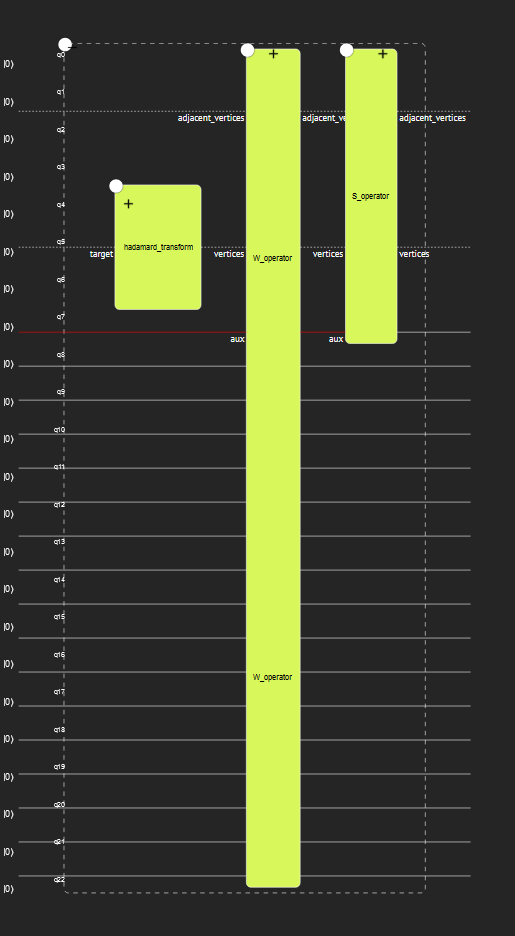
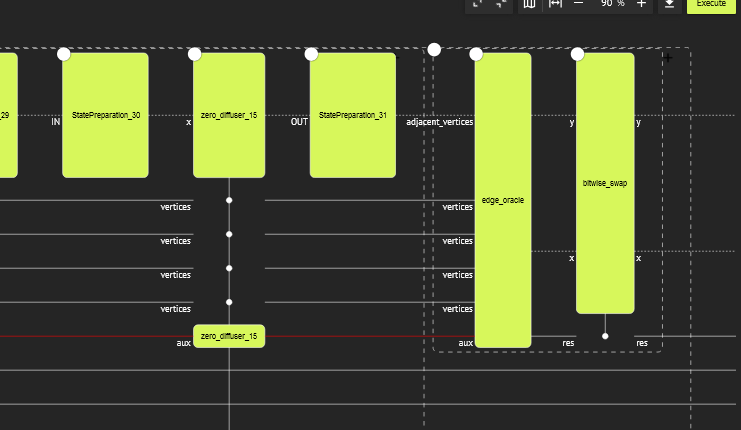